In [ ]:
import json # just for now it's easier to keep data in json

import pandas as pd # for dataFrames

import seaborn as sns # for fancy plots

Data is loaded from json and stored to the DataFrame

In [ ]:
with open('/content/coordinates_38920.json') as f:
  data_big = json.load(f)

coords_big = data_big['geometries'][0]['coordinates'][0][0]
coords_big_df = pd.DataFrame({'longitude': [i[0] for i in coords_big[::3]], 'latitude': [i[1] for i in coords_big[::3]]})
coords_big_df.head()

,longitude,latitude
0,22.137889,48.425040
1,22.138287,48.414586
2,22.142802,48.411285
3,22.142242,48.408219
4,22.143973,48.403844


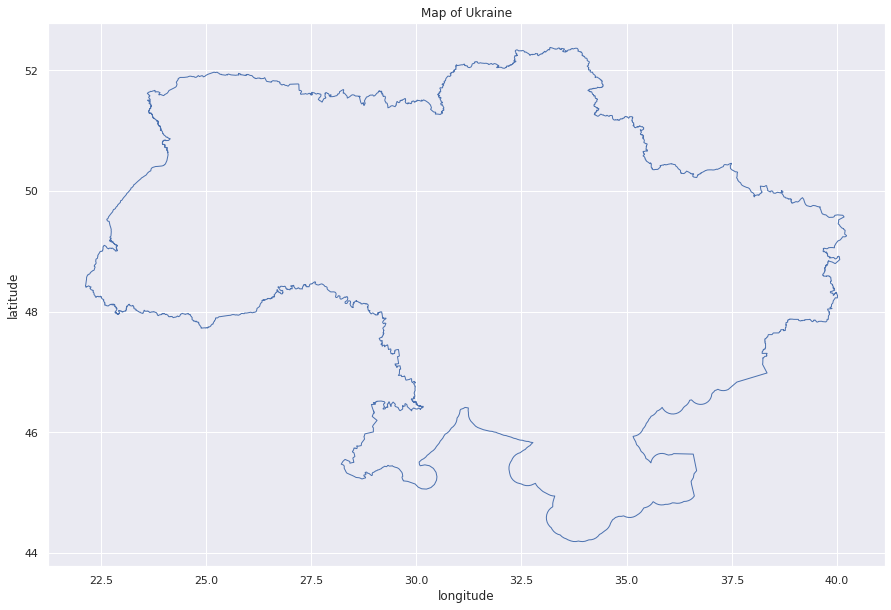

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(x='longitude', y='latitude', data=coords_big_df, sort=False, lw=1).set_title("Map of Ukraine");

This map is quite detailed, so it's quite complicated to define if the point is inside the map manualy. The best solution I found is to use polygons and the [library](https://shapely.readthedocs.io/en/latest/) that works with this kind of geometrical objects. 

In [ ]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

maps = Polygon(coords_big)

It works fast enough (or at least faster than a manually writen code). For example check if the point is inside the map takes no more that 40 ms for both True and False.

In [ ]:
%%time
maps.contains(Point((25.,45.)))

CPU times: user 39.4 ms, sys: 0 ns, total: 39.4 ms
Wall time: 40.9 ms


False

In [ ]:
%%time
maps.contains(Point((34.,45.)))

CPU times: user 38.8 ms, sys: 0 ns, total: 38.8 ms
Wall time: 42 ms


True

In [ ]:
'''
function to check if the point (one of the map contour coord)
is inside the square
'''
def inside(point,coord):
  return point[0] > coord[0][0] and point[0] < coord[1][0] and point[1] > coord[0][1] and point[1] < coord[2][1]


'''
return all of the coords of the contour that fit into our square
'''
def cut_piece(coords):
  (x1,y1),(x2,y2),(x3,y3),(x4,y4) = coords
  # we can not just check if each corner of the square is inside the map because the map is not convex
  # for example if we check (30,46),(32.5,46),(30,48),(32.5,48) all corners are inside, but the figure is concave
  # so we actuale should check every point
  return [i for i in coords_big if inside(i, coords)]

For example we cut a part of Odessa to show the algorithm works.

In [ ]:
%%time
piece = cut_piece([(28.,45.),(30.,45.),(28.,46.5),(30.,46.5)])

CPU times: user 14.3 ms, sys: 0 ns, total: 14.3 ms
Wall time: 19.7 ms


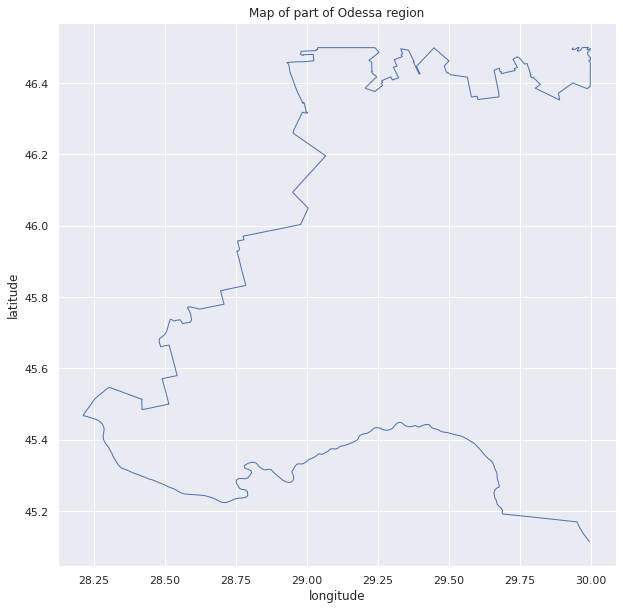

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
piece_df = pd.DataFrame({'longitude': [i[0] for i in piece], 'latitude':[i[1] for i in piece]})
sns.lineplot(x ='longitude', y ='latitude', data = piece_df, sort=False, lw=1).set_title("Map of part of Odessa region");

To calculate min/max coordinates of Ukraine

In [ ]:
latitude_min = min([i[1] for i in coords_big])
latitude_max = max([i[1] for i in coords_big])

longitude_min = min([i[0] for i in coords_big])
longitude_max = max([i[0] for i in coords_big])

print('Latitude: {} - {}\nLongitude: {} - {}'.format(latitude_min, latitude_max, longitude_min, longitude_max))

Latitude: 44.1845979 - 52.3797464
Longitude: 22.1370589 - 40.2275801


In general to calculate the actual length of the 1 degree on the map we need to use this formulas:
 - km_in_degree_longtitude = 111.134861111
 - km_in_degree_latitude = 111.134861111

In [ ]:
km_in_degree_longitude = 111.321377778
km_in_degree_latitude = 111.134861111

In [ ]:
import math
print('The difference of the length of 1 degree: ', end = '')
print(km_in_degree_longitude*(math.cos(math.radians(latitude_min))-math.cos(math.radians(latitude_max))))

The difference of the length of 1 degree: 11.8749628443405


And as we can see for different points on the map the actual km_in_degree_latitude is almost 12 km bigger.

In [ ]:
print('Latitude: ',km_in_degree_latitude)
print('Longitude: ',km_in_degree_longitude*math.cos(math.radians(latitude_min)), km_in_degree_longitude*math.cos(math.radians(latitude_max)))

Latitude:  111.134861111
Longitude:  79.8283364518405 67.9533736075


In [ ]:
map_squares = {}
coord_current = latitude_min
while coord_current < latitude_max+1/km_in_degree_latitude:
  map_squares[coord_current] = {}
  coord_current += 1/km_in_degree_latitude

In [ ]:
map_squares.keys()

dict_keys([44.1845979, 44.19359597666112, 44.202594053322244, 44.211592129983366, 44.22059020664449, 44.22958828330561, 44.23858635996673, 44.247584436627854, 44.256582513288976, 44.2655805899501, 44.27457866661122, 44.28357674327234, 44.29257481993346, 44.301572896594585, 44.31057097325571, 44.31956904991683, 44.32856712657795, 44.33756520323907, 44.346563279900195, 44.35556135656132, 44.36455943322244, 44.37355750988356, 44.38255558654468, 44.391553663205805, 44.40055173986693, 44.40954981652805, 44.41854789318917, 44.42754596985029, 44.436544046511415, 44.44554212317254, 44.45454019983366, 44.46353827649478, 44.4725363531559, 44.481534429817025, 44.49053250647815, 44.49953058313927, 44.50852865980039, 44.51752673646151, 44.526524813122634, 44.535522889783756, 44.54452096644488, 44.553519043106, 44.56251711976712, 44.571515196428244, 44.580513273089366, 44.58951134975049, 44.59850942641161, 44.60750750307273, 44.616505579733854, 44.625503656394976, 44.6345017330561, 44.64349980971722

In [ ]:
def closest_smaller(coord, min_value, km_1):
  return coord - (coord-min_value)%km_1

closest_smaller(7.7, 7, 0.5)

7.5

In [ ]:
for coords in coords_big:
  print(coords, closest_smaller(coords[1], latitude_min, 1/km_in_degree_latitude))
  map_squares[closest_smaller(coords[1], latitude_min, 1/km_in_degree_latitude)][closest_smaller(coords[0], longitude_min, 1/km_in_degree_longitude)] = 1

[22.1378889, 48.42504] 48.42269200738878


KeyError: ignored